In [1]:
import requests
import yaml
from datetime import datetime
format = "%H:%M:%S.%f"
from astropy import units as u
from astropy.coordinates import SkyCoord
import json
import numpy as np
import math
from astropy.coordinates import Galactic,Angle, Latitude, Longitude
import pandas as pd
from matplotlib import figure
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# We retrieve the set of FRBs which have been detected relevant to our study:
# Set the range/specific FRBs to be identified
frb = "FRB20"

# Make GET request to FRBSTATS
response = requests.get("https://www.herta-experiment.org/frbstats/api/search?frb=" + frb)
# The FRB information is retrieved in Json format

In [3]:
jsonFRB= json.loads(response.text)
class obj:
     
    # constructor
    def __init__(self, dict1):
        self.__dict__.update(dict1)

# Function to take in a dictionary and return an object
def dict2obj(dict1):
     
    # using json.loads method and passing json.dumps
    # method and custom object hook as arguments
    return json.loads(json.dumps(dict1), object_hook=obj)


# Now convert it into an list of objects, each object representing given FRB
FRBS = []
for item in jsonFRB:
    FRBS.append(dict2obj(item))

In [4]:
# Each attribute of the FRB is also stored as list, for easier access and statistical analysis:

# Storing names of the FRB
FRBnames= []
for item in FRBS:
    FRBnames.append(item.frb)
        
# Telescopes which detected them
Telescopes = []
for item in FRBS:
    Telescopes.append(item.telescope)
    
# Dispersion measure for given FRB    
dms =[]
for items in FRBS:
    dms.append(float((items.dm)))
    
# Peak flux density for given FRB
fluxes = []
for items in FRBS:
    if items.flux == '-':
        fluxes.append(None)
    else:
        fluxes.append(float((items.flux)))

# Galactic co-ordinates in terms of right ascension and declination
coords = []
for items in FRBS:
    if items.ra == '-':
        coords.append(None)
    else:
        coords.append(SkyCoord(items.ra,items.dec, unit = (u.hourangle, u.deg)))

# Storing RA values in a list
ras = []
for items in coords:
    if items.ra == '-':
        ras.append(None)
    else:
        ras.append(items.ra.wrap_at(180*u.degree))
        
# Storing RA values in a list        
decs = []
for items in coords:
    if items.ra == '-':
        decs.append(None)
    else:
        decs.append(items.dec)       
        
# Galactic co-ordinates in terms of longitude and latitude  
galCoords= []
for items in FRBS:
    if items.ra == '-':
        galCoords.append(None)
    else:
        galCoords.append(SkyCoord(items.l,items.b,frame='galactic', unit = (u.deg, u.deg)))

# Storing longitude values in a list
longis= []
for items in galCoords:
    longis.append(items.l.wrap_at(180*u.degree))

# Storing latitude values in a list
lats= []
for items in galCoords:
        lats.append(items.b)

# Fluence values for given FRB
fluences = []
for items in FRBS:
    if items.fluence == "-":
        fluences.append(None)
    else:
        fluences.append(float(items.fluence))
        
#Center frequency of the FRB detected        
frequencies = []
for items in FRBS:
    if items.frequency == "-":
        frequencies.append(None)
    else:
        frequencies.append(float(items.frequency))    

#converting the Galactic co-ordinates into astropy co-ordinates        
Skyco = SkyCoord(coords)
Galco = SkyCoord(galCoords)

In [5]:
# Converting values of RA and dec into radian:

ra_rad = Skyco.ra.radian
# RA needs to be wrapped to -180 to 180 before we make the plots
ra_rad[ra_rad > np.pi] -= 2. * np.pi

dec_rad = Skyco.dec.radian

In [6]:
# Converting values of RA and dec into degrees:

ra_deg = Skyco.ra.degree

dec_deg = Skyco.dec.degree

In [7]:
# Converting values of longitude and latitude into radian:

l_rad = Galco.l.radian
# Longitude needs to be wrapped to -180 to 180 before we make the plots
l_rad[l_rad > np.pi] -= 2. * np.pi

b_rad = Galco.b.radian

In [8]:
# Converting values of RA and dec into degrees:

l_deg = Galco.l.degree

b_deg = Galco.b.degree

In [9]:
# Making the dataframe for all the relevant FRBS
FRBprops= pd.DataFrame({"DM":dms,"flux": fluxes, "coord":coords,"ra":ra_rad, "telescope": Telescopes, \
                        "dec":dec_rad, "l":l_rad, "b":b_rad , "RA":ra_deg, "DEC": dec_deg,\
                       "L":l_deg, "B": b_deg, "fluence":fluences, "frequency": frequencies})

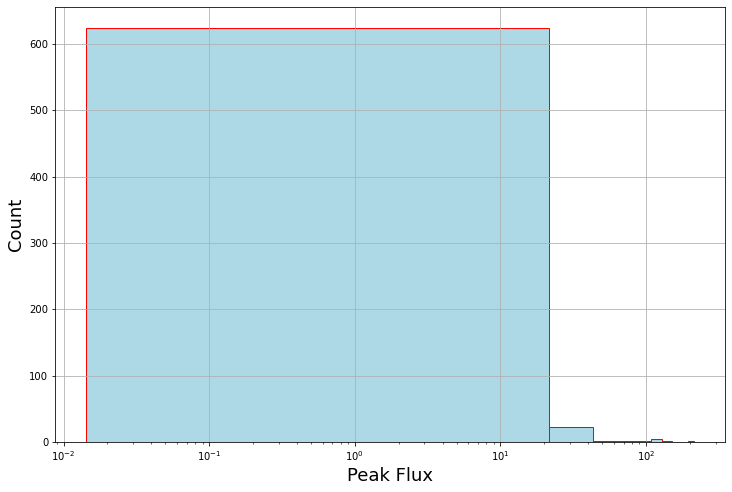

In [10]:
# Plotting Peak flux density histrogram
fig = plt.figure(figsize=(12,8))
plot1= FRBprops["flux"].plot(kind = "hist", logx =True, color = 'lightblue', ec = 'Red', grid =True)
plt.xlabel("Peak Flux", fontsize = 18)
plt.ylabel("Count",  fontsize = 18)
plt.savefig("Peak flux histogram.pdf", bbox_inches = "tight")

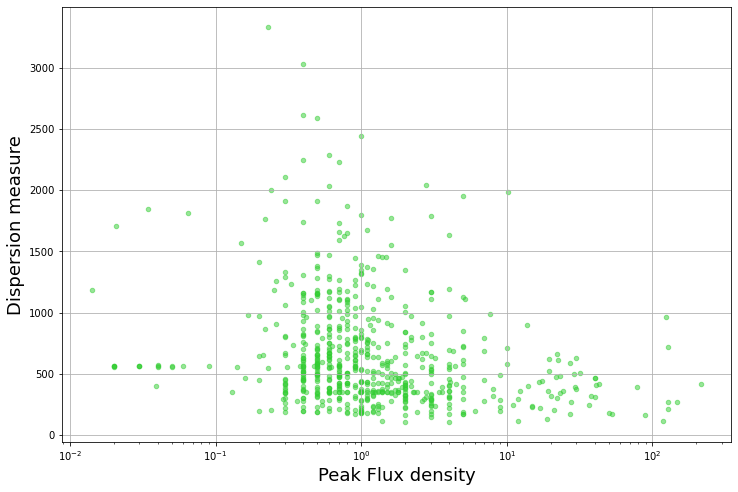

In [11]:
# Plotting Peak flux vs Dispersion measure

plot2 =FRBprops.plot.scatter(x="flux",logx=True, y ="DM", color = "limegreen", alpha = 0.5, figsize = (12,8), grid = True)
plot2.set_xlabel("Peak Flux density",  fontsize = 18)
plot2.set_ylabel("Dispersion measure", fontsize = 18)
plt.savefig("Peak Flux density vs Dispersion Measure.pdf", bbox_inches = "tight")

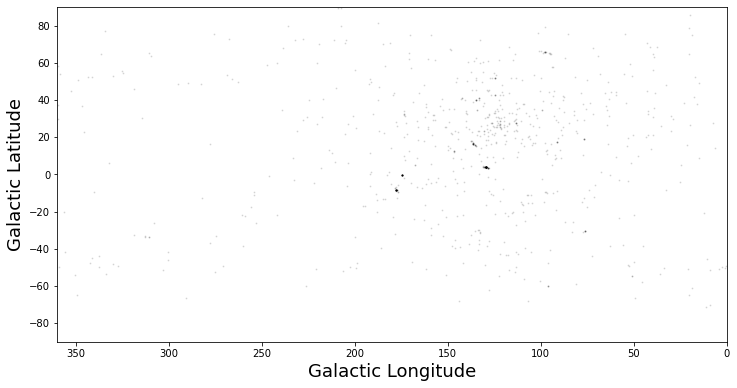

<Figure size 432x288 with 0 Axes>

In [12]:
# Plotting FRBs detected across longitude and latitude on rectangular plot:

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1, aspect='equal',)
ax.scatter(Galco.l.degree, Galco.b.degree, s=1, color='black', alpha=0.1,)
ax.set_xlim(360., 0.)
ax.set_ylim(-90., 90.)
ax.set_xlabel("Galactic Longitude", fontsize = 18)
ax.set_ylabel("Galactic Latitude", fontsize = 18)
plt.show()
plt.savefig("FRBS detected across Sky.pdf")

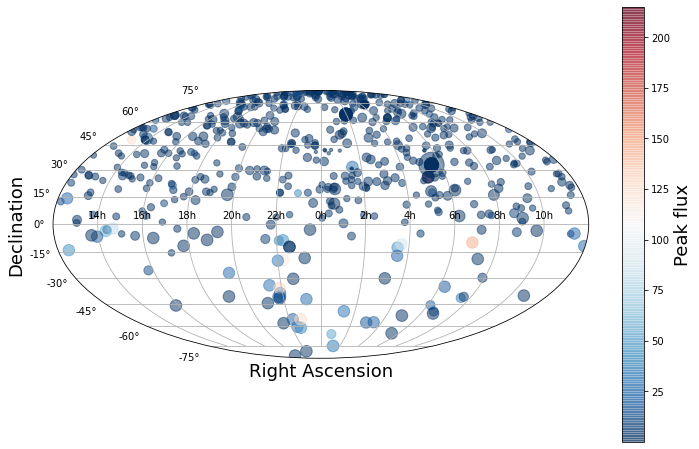

In [13]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="mollweide")
a =ax.scatter(FRBprops['ra'],FRBprops['dec'], c = FRBprops["flux"], cmap ="RdBu_r", s= FRBprops["frequency"]*0.1, alpha =0.5 )
a1=plt.colorbar(a)
a1.set_label('Peak flux', fontsize = 18)
ax.set_xlabel("Right Ascension", fontsize = 18)
ax.set_ylabel("Declination", fontsize = 18)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
plt.savefig("FRBS detected across sky (RA-dec), Peak flux density and Center frequency.pdf")
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)

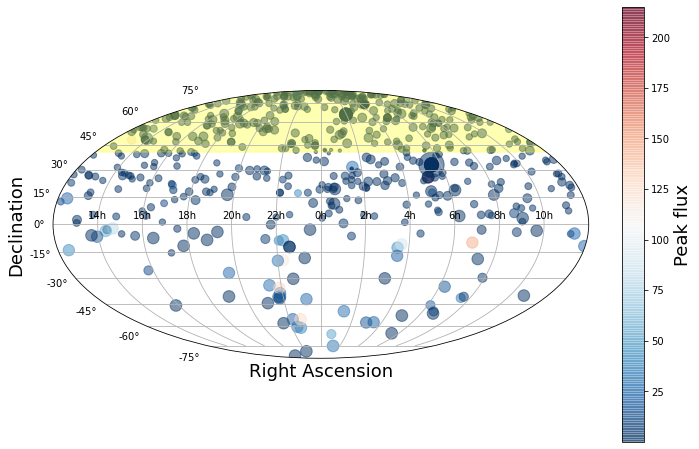

In [44]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="mollweide")
a =ax.scatter(FRBprops['ra'],FRBprops['dec'], c = FRBprops["flux"], cmap ="RdBu_r", s= FRBprops["frequency"]*0.1, alpha =0.5 )
a1=plt.colorbar(a)
a1.set_label('Peak flux', fontsize = 18)
ax.set_xlabel("Right Ascension", fontsize = 18)
ax.set_ylabel("Declination", fontsize = 18)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
plt.axhspan(0.7099723251101, 1.5708, color='yellow', alpha=0.3)
plt.savefig("FRBS detected across sky (CHIME), Peak flux density and Center frequency.pdf")


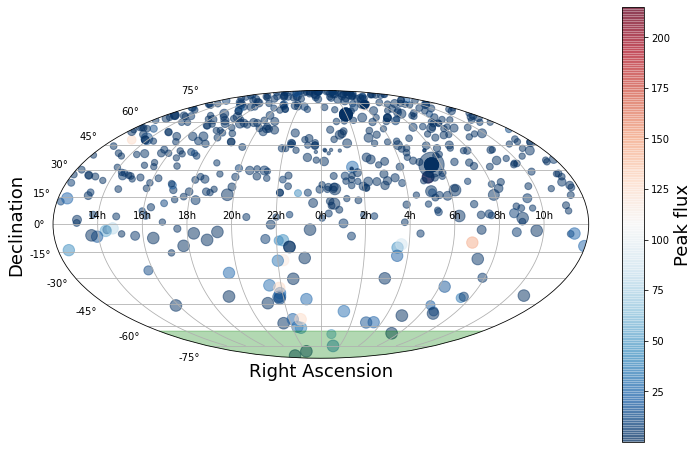

In [45]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="mollweide")
a =ax.scatter(FRBprops['ra'],FRBprops['dec'], c = FRBprops["flux"], cmap ="RdBu_r", s= FRBprops["frequency"]*0.1, alpha =0.5 )
a1=plt.colorbar(a)
a1.set_label('Peak flux', fontsize = 18)
ax.set_xlabel("Right Ascension", fontsize = 18)
ax.set_ylabel("Declination", fontsize = 18)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
plt.axhspan(-1.1048012705, -1.5708, color='green', alpha=0.3)
plt.savefig("FRBS detected across sky (AKAP), Peak flux density and Center frequency.pdf")


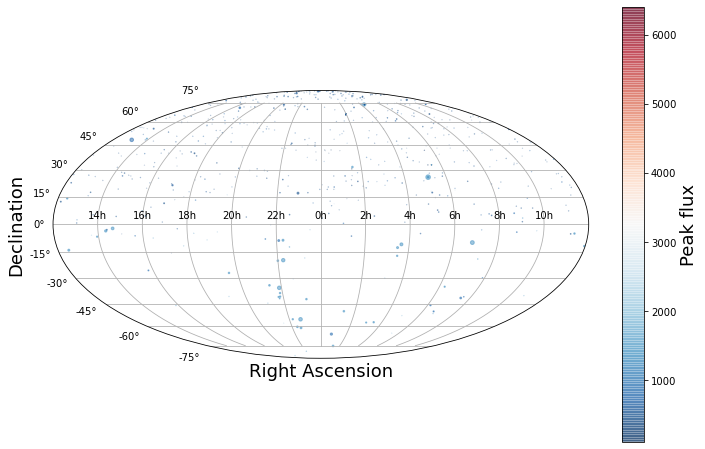

In [16]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="mollweide")
a =ax.scatter(FRBprops['ra'],FRBprops['dec'], c = FRBprops["frequency"], cmap ="RdBu_r", s= FRBprops["flux"]*0.1, alpha =0.5 )
a1=plt.colorbar(a)
a1.set_label('Peak flux', fontsize = 18)
ax.set_xlabel("Right Ascension", fontsize = 18)
ax.set_ylabel("Declination", fontsize = 18)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
plt.savefig("FRBS detected across sky, Peak flux density and Center frequency.pdf")

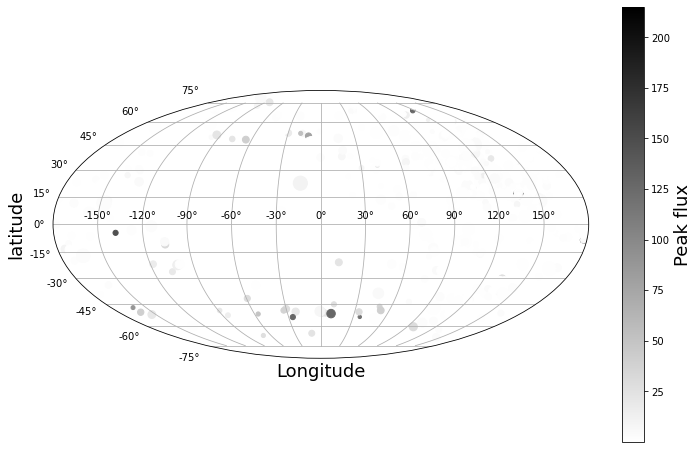

In [17]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="mollweide")
b = ax.scatter(FRBprops['l'],FRBprops['b'], c = FRBprops["flux"], cmap ="binary", s = FRBprops["DM"]*0.1, alpha = 1)
b1=plt.colorbar(b)
b1.set_label('Peak flux', fontsize = 18)
ax.set_xlabel("Longitude", fontsize = 18)
ax.set_ylabel("latitude",fontsize = 18)
ax.grid(True)
plt.savefig("FRBS detected across sky, Peak flux density and Center frequency.pdf")

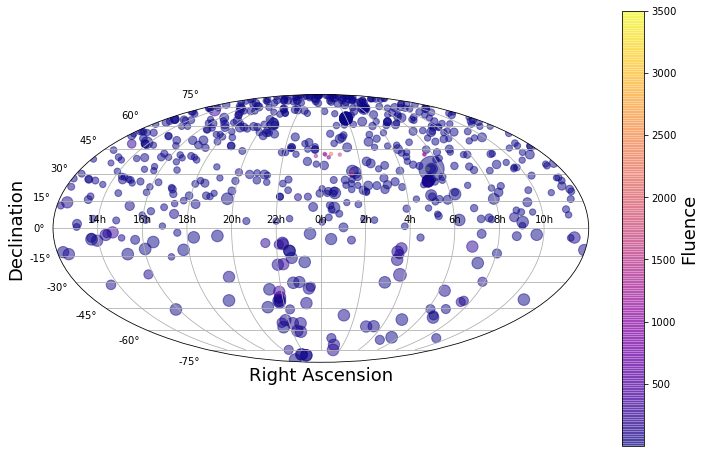

In [18]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="mollweide")
c =ax.scatter(FRBprops['ra'],FRBprops['dec'], c = FRBprops["fluence"], cmap ="plasma", s= FRBprops["frequency"]*0.1, alpha =0.5 )
c1=plt.colorbar(c)
c1.set_label('Fluence', fontsize = 18)
ax.set_xlabel("Right Ascension", fontsize = 18)
ax.set_ylabel("Declination", fontsize = 18)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
plt.savefig("FRBS detected across sky, fluence and Center frequency.pdf")

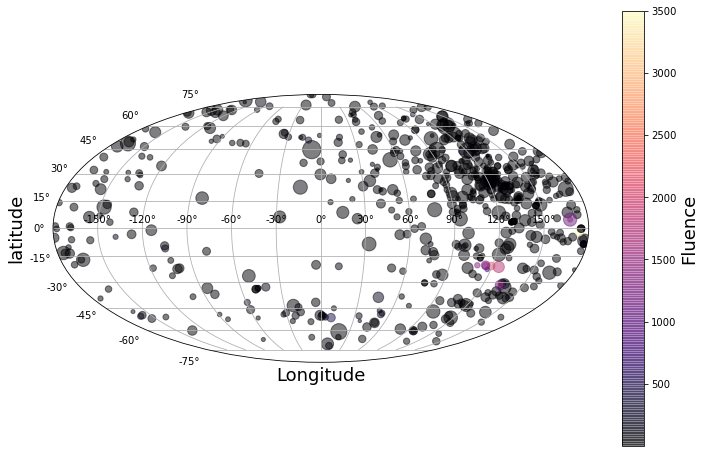

In [19]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="mollweide")
d = ax.scatter(FRBprops['l'],FRBprops['b'], c = FRBprops["fluence"], cmap ="magma", s = FRBprops["DM"]*0.1, alpha = 0.5)
d1=plt.colorbar(d)
d1.set_label('Fluence',fontsize = 18)
ax.set_xlabel("Longitude", fontsize = 18)
ax.set_ylabel("latitude", fontsize = 18)
ax.grid(True)
plt.savefig("FRBS detected across sky(GAL co), fluence and Center frequency.pdf")


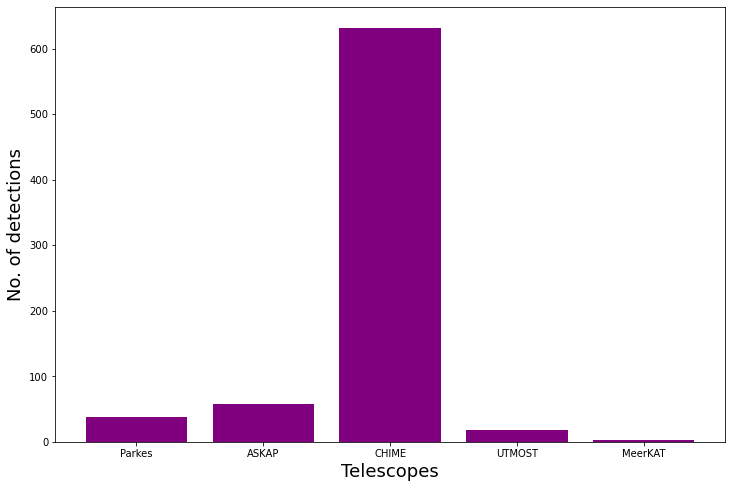

In [20]:
#Plotting detections by different telescopes: 

p= 0
for x in range(0, len(FRBprops)):
    if  FRBprops['telescope'][x]== 'Parkes':
        p = p+1
a= 0
for x in range(0, len(FRBprops)):
    if  FRBprops['telescope'][x]== 'ASKAP':
        a = a+1
c= 0
for x in range(0, len(FRBprops)):
    if  FRBprops['telescope'][x]== 'CHIME':
        c = c+1        
        
u= 0
for x in range(0, len(FRBprops)):
    if  FRBprops['telescope'][x]== 'UTMOST':
        u = u+1    
        
m= 0
for x in range(0, len(FRBprops)):
    if  FRBprops['telescope'][x]== 'MeerKAT':
        m = m+1
# The above code counts detections, while below plots its
        
telescopies = ["Parkes", "ASKAP", "CHIME", "UTMOST", "MeerKAT"]
numbers = [p, a ,c ,u ,m]
fig = plt.figure(figsize=(12,8))
ax =plt.bar(telescopies, numbers, color = "purple")
plt.xlabel("Telescopes", fontsize = 18)
plt.ylabel("No. of detections", fontsize = 18)
plt.savefig("Detections by respective Telescopes")


In [21]:
# We take in inputs to only output FRBs with given parameters

freq_low = float(input("Enter the lower limit of frequency (in GHz): "))
DM_low = float(input("Enter the lower limit of dispersion measure (in pc cm^(-3)): "))
flux_low = float(input("Enter the lower limit of Peak flux density (in Jy): "))
fluence_low = float(input("Enter the lower limit of Fluence (Jy ms): "))

Enter the lower limit of frequency (in GHz): 0
Enter the lower limit of dispersion measure (in pc cm^(-3)): 0
Enter the lower limit of Peak flux density (in Jy): 0
Enter the lower limit of Fluence (Jy ms): 0


In [22]:
# We get the dataframe containing all the relevant FRBs
needed = FRBprops[(FRBprops["flux"]>flux_low) & (FRBprops["DM"]>DM_low) & (FRBprops["frequency"]> (1000*freq_low)) & \
                  (FRBprops['fluence']>fluence_low)]    

Text(0.5, 1.0, 'Peak flux histogram')

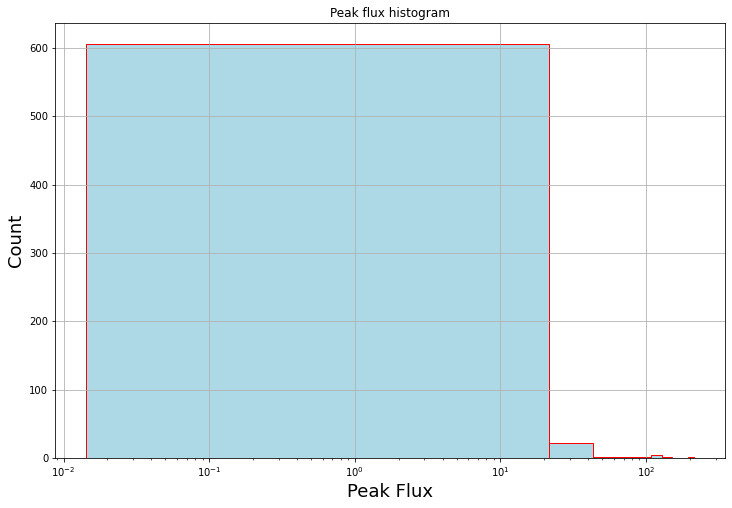

In [23]:
# We plot this fitlered data:

# Plotting Peak flux density histrogram
fig = plt.figure(figsize=(12,8))
plot1= needed["flux"].plot(kind = "hist", logx =True, color = 'lightblue', ec = 'Red', grid =True)
plot1.set_xlabel("Peak Flux", fontsize = 18)
plot1.set_ylabel("Count", fontsize = 18)
plot1.set_title("Peak flux histogram")

Text(0, 0.5, 'Dispersion measure')

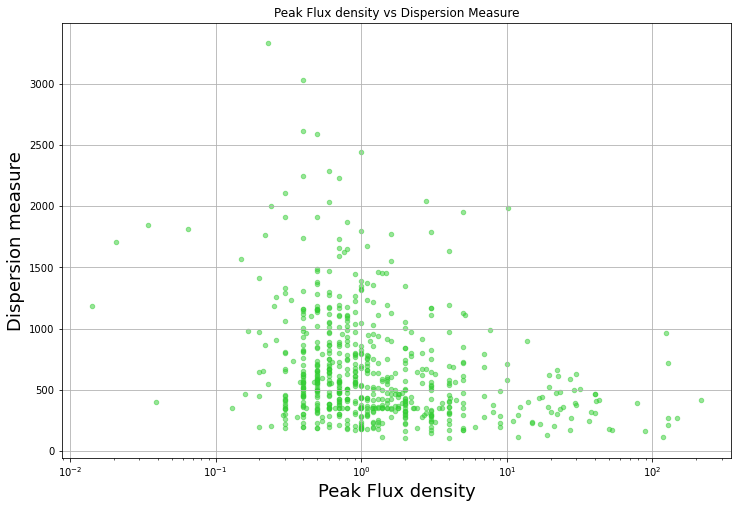

In [24]:
# Plotting Peak flux vs Dispersion measure

plot2 =needed.plot.scatter(x="flux",logx=True, y ="DM", color = "limegreen", alpha = 0.5, figsize = (12,8), grid = True)
plot2.set_title("Peak Flux density vs Dispersion Measure")
plot2.set_xlabel("Peak Flux density", fontsize = 18)
plot2.set_ylabel("Dispersion measure", fontsize = 18)


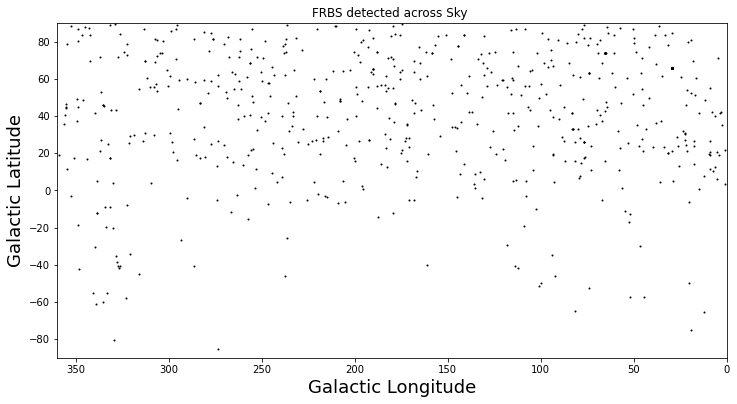

In [25]:
# Plotting FRBs detected across longitude and latitude on rectangular plot:

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1, aspect='equal',)
ax.scatter(needed["RA"],needed["DEC"], s=1, color='black', alpha=1,)
ax.set_xlim(360., 0.)
ax.set_ylim(-90., 90.)
ax.set_xlabel("Galactic Longitude", fontsize = 18)
ax.set_ylabel("Galactic Latitude", fontsize = 18)
ax.set_title("FRBS detected across Sky ")
plt.show()

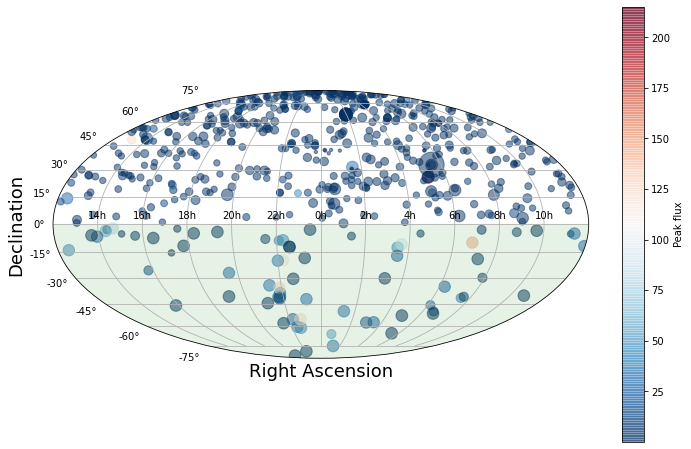

In [36]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="mollweide")
a =ax.scatter(needed['ra'],needed['dec'], c = needed["flux"], cmap ="RdBu_r", s= needed["frequency"]*0.1, alpha =0.5 )
a1=plt.colorbar(a)
a1.set_label('Peak flux')
ax.set_xlabel("Right Ascension", fontsize = 18)
ax.set_ylabel("Declination",fontsize = 18)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
plt.axhspan(-1.5708, 0, color='green', alpha=0.1)
plt.savefig("FRBS detected across sky, by Antarctica.pdf")



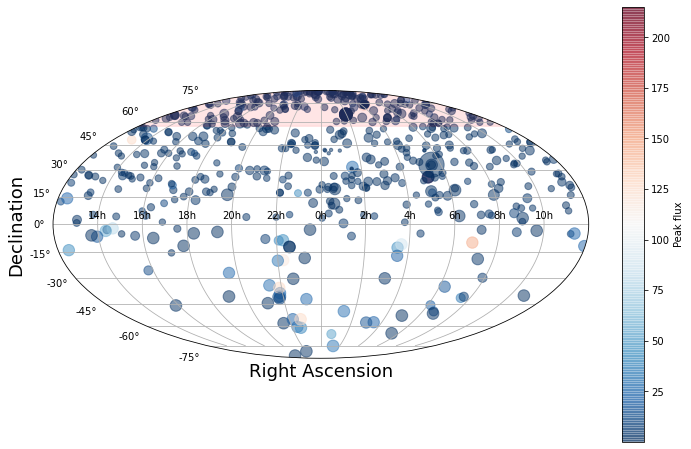

In [37]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="mollweide")
a =ax.scatter(needed['ra'],needed['dec'], c = needed["flux"], cmap ="RdBu_r", s= needed["frequency"]*0.1, alpha =0.5 )
a1=plt.colorbar(a)
a1.set_label('Peak flux')
ax.set_xlabel("Right Ascension", fontsize = 18)
ax.set_ylabel("Declination", fontsize = 18)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
plt.axhspan(0.9984889024, 1.5708, color='red', alpha=0.1)
plt.savefig("FRBS detected across sky, by Hanle.pdf")


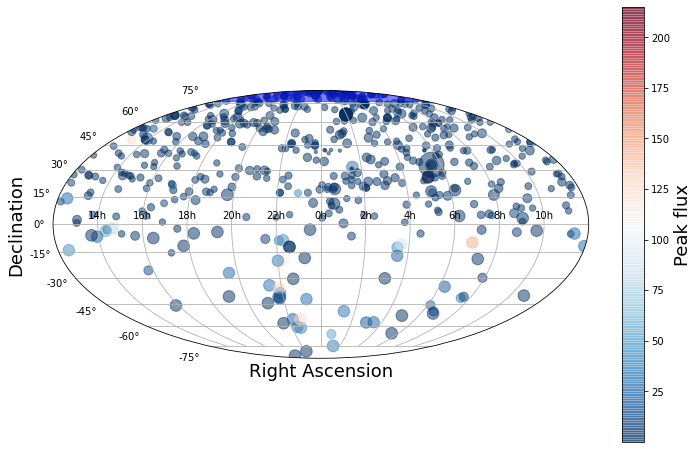

In [38]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="mollweide")
a =ax.scatter(needed['ra'],needed['dec'], c = needed["flux"], cmap ="RdBu_r", s= needed["frequency"]*0.1, alpha =0.5 )
a1=plt.colorbar(a)
a1.set_label('Peak flux', fontsize = 18)
ax.set_xlabel("Right Ascension", fontsize = 18)
ax.set_ylabel("Declination", fontsize = 18)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
plt.axhspan(1.33337919, 1.5708, color='blue', alpha=0.5)
plt.savefig("FRBS detected across sky, by GBD.pdf")


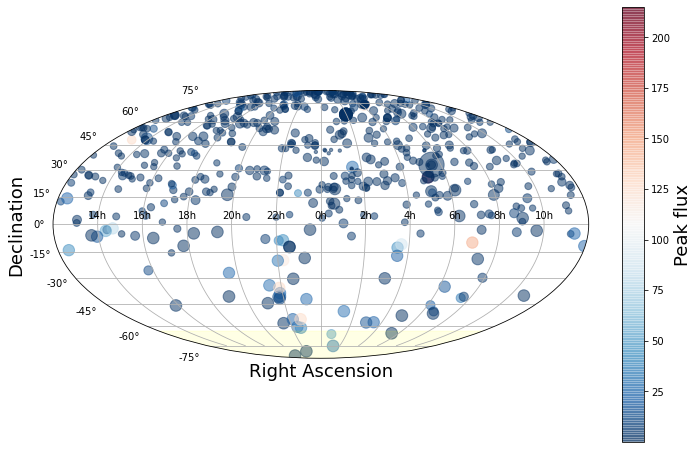

In [39]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="mollweide")
a =ax.scatter(needed['ra'],needed['dec'], c = needed["flux"], cmap ="RdBu_r", s= needed["frequency"]*0.1, alpha =0.5 )
a1=plt.colorbar(a)
a1.set_label('Peak flux', fontsize = 18)
ax.set_xlabel("Right Ascension", fontsize = 18)
ax.set_ylabel("Declination", fontsize = 18)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
plt.axhspan(-1.104735821, -1.5708, color='yellow', alpha=0.1)
plt.savefig("FRBS detected across sky, by Mwa.pdf")


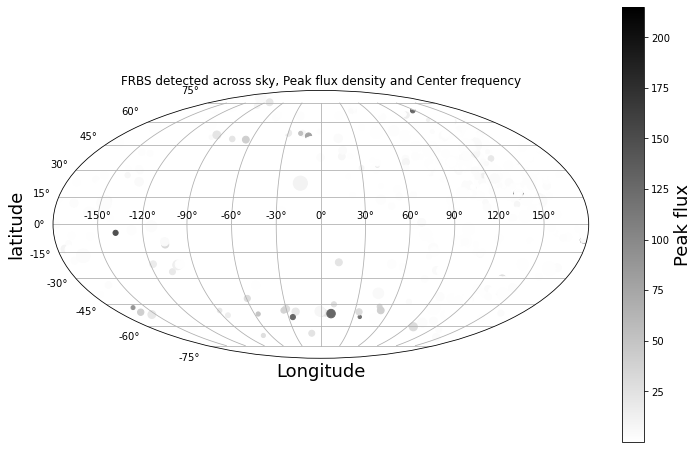

In [30]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="mollweide")
b = ax.scatter(needed['l'],needed['b'], c = needed["flux"], cmap ="binary", s = needed["DM"]*0.1, alpha = 1)
b1=plt.colorbar(b)
b1.set_label('Peak flux', fontsize = 18)
ax.set_xlabel("Longitude", fontsize = 18)
ax.set_ylabel("latitude", fontsize = 18)
ax.set_title("FRBS detected across sky, Peak flux density and Center frequency")
ax.grid(True)

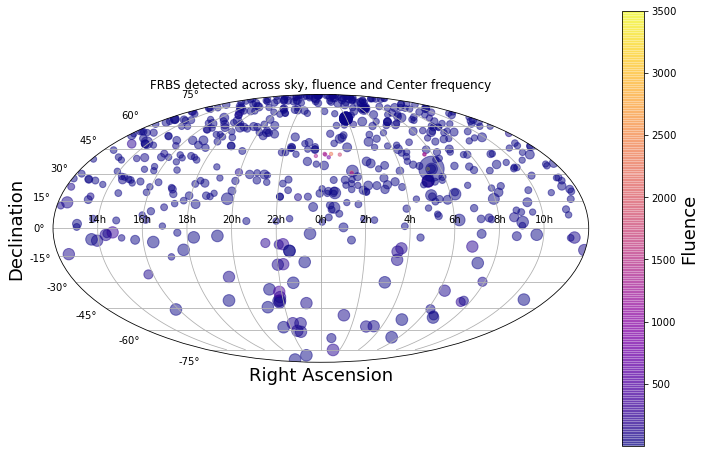

In [31]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="mollweide")
c =ax.scatter(needed['ra'],needed['dec'], c = needed["fluence"], cmap ="plasma", s= needed["frequency"]*0.1, alpha =0.5 )
c1=plt.colorbar(c)
c1.set_label('Fluence', fontsize = 18)
ax.set_xlabel("Right Ascension", fontsize = 18)
ax.set_ylabel("Declination", fontsize = 18)
ax.set_title("FRBS detected across sky, fluence and Center frequency")
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)

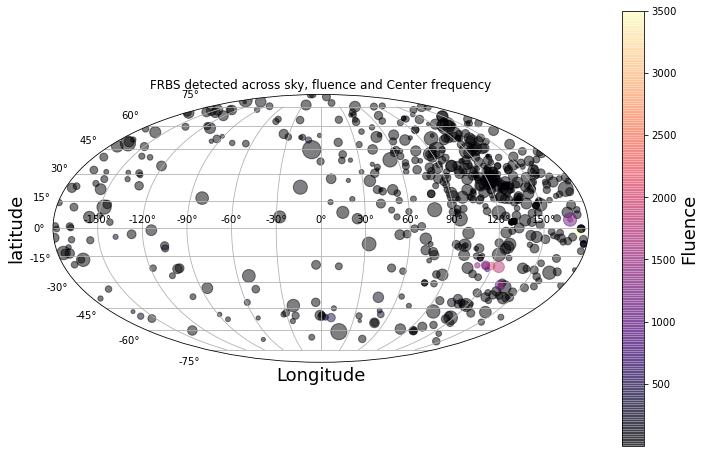

In [32]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="mollweide")
d = ax.scatter(needed['l'],needed['b'], c = needed["fluence"], cmap ="magma", s = needed["DM"]*0.1, alpha = 0.5)
d1=plt.colorbar(d)
d1.set_label('Fluence', fontsize = 18)
ax.set_xlabel("Longitude", fontsize = 18)
ax.set_ylabel("latitude", fontsize = 18)
ax.set_title("FRBS detected across sky, fluence and Center frequency")
ax.grid(True)